In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/edsa-movie-recommendation-predict/sample_submission.csv
/kaggle/input/edsa-movie-recommendation-predict/movies.csv
/kaggle/input/edsa-movie-recommendation-predict/imdb_data.csv
/kaggle/input/edsa-movie-recommendation-predict/genome_tags.csv
/kaggle/input/edsa-movie-recommendation-predict/genome_scores.csv
/kaggle/input/edsa-movie-recommendation-predict/train.csv
/kaggle/input/edsa-movie-recommendation-predict/test.csv
/kaggle/input/edsa-movie-recommendation-predict/tags.csv
/kaggle/input/edsa-movie-recommendation-predict/links.csv


In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
import difflib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from time import time

In [15]:
data_folder = '/kaggle/input/edsa-movie-recommendation-predict/'
#data_folder = 'C:/Users/ADMIN/Desktop/unsupervised_project/'
train = pd.read_csv(data_folder + 'train.csv')
test = pd.read_csv(data_folder + 'test.csv')
tags = pd.read_csv(data_folder + 'tags.csv')
movies = pd.read_csv(data_folder + 'movies.csv')
links = pd.read_csv(data_folder + 'links.csv')
imdb = pd.read_csv(data_folder + 'imdb_data.csv')
genome_tags = pd.read_csv(data_folder + 'genome_tags.csv')
genome_scores = pd.read_csv(data_folder + 'genome_scores.csv')

In [8]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
imdb.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [10]:
tags.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [11]:
genome_tags.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [12]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [16]:
genome_scores.head()

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [17]:
train.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [18]:
test.head()

,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


In [19]:
list_of_all_dataframes = [ movies, imdb, tags, links, genome_scores, genome_tags, train, test ]

for each in list_of_all_dataframes:
    print(each.shape)
# https://stackoverflow.com/questions/68158905/using-for-loop-to-print-shape-of-multiple-dataframes

(62423, 3)
(27278, 6)
(1093360, 4)
(62423, 3)
(15584448, 3)
(1128, 2)
(10000038, 4)
(5000019, 2)


### From above, it is observed that:

* movies has ~63 500 rows, and 3 columns
* imdb has ~27 300 rows, and 6 columns
* tags has ~1.1M rows, and 4 columns
* links has ~62 300 rows, and 3 columns
* genome_scores has ~15.6M rows, and 3 columns
* genome_tags has ~1100 rows, and 2 columns
* train has ~10M rows, and 4 columns
* test has ~5M rows, and 2 columns

In [20]:
average_rating = round(train.rating.mean(),2)  # To 2 decimal places
average_rating

3.53

In [21]:
movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [22]:
imdb.isnull().sum()

movieId              0
title_cast       10068
director          9874
runtime          12089
budget           19372
plot_keywords    11078
dtype: int64

In [23]:
tags.isnull().sum()

userId        0
movieId       0
tag          16
timestamp     0
dtype: int64

In [24]:
links.isnull().sum()

movieId      0
imdbId       0
tmdbId     107
dtype: int64

In [25]:
genome_scores.isnull().sum()

movieId      0
tagId        0
relevance    0
dtype: int64

In [28]:
genome_tags.isnull().sum()

tagId    0
tag      0
dtype: int64

In [29]:
train.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [30]:
test.isnull().sum()

userId     0
movieId    0
dtype: int64

Text(0.5, 1.0, 'MISSING VALUES IN EACH COLUMN')

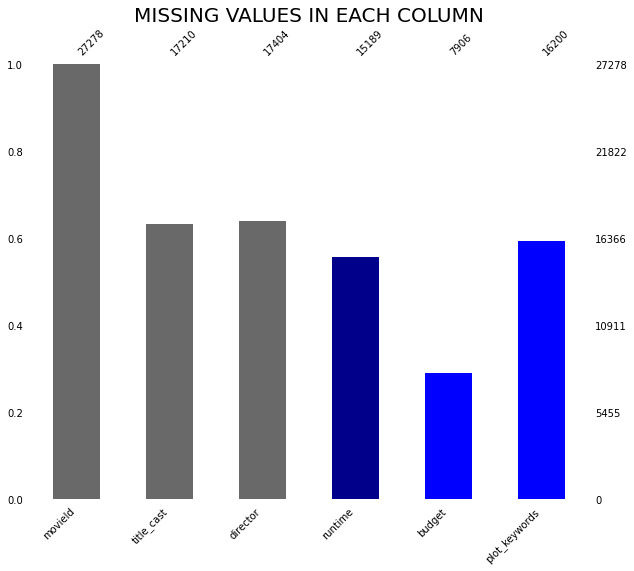

In [32]:
import missingno #Python library for the exploratory visualization of missing data #install using !pip install missingno
color= ['dimgrey','dimgrey','dimgrey','darkblue','blue','blue','lightblue','dimgrey','dimgrey','dimgrey','dimgrey','dimgrey']
missingno.bar(imdb,fontsize=10,color=color,figsize=(10,8))
plt.title('MISSING VALUES IN EACH COLUMN',fontsize=20)

In [33]:
df_budget = imdb.sort_values(by='budget',ascending=False)
print(df_budget.budget)

14584    ZAR10,000,000
23579     VEB4,273,248
24115        UAH10,000
24673    TWD50,000,000
15111    TWD45,000,000
             ...      
27271              NaN
27273              NaN
27275              NaN
27276              NaN
27277              NaN
Name: budget, Length: 27278, dtype: object


In [34]:
movies_ =imdb.sort_values(by='budget',ascending=False)
print(movies_.budget.str[0:3].unique())

['ZAR' 'VEB' 'UAH' 'TWD' 'TRL' 'THB' 'SIT' 'SGD' 'SEK' 'RUR' 'PTE' 'PLN'
 'PHP' 'NZD' 'NOK' 'NLG' 'NGN' 'MYR' 'MXN' 'LVL' 'LTL' 'KRW' 'JPY' 'ITL'
 'ISK' 'IRR' 'INR' 'ILS' 'IDR' 'HUF' 'HKD' 'GBP' 'FRF' 'FIM' 'EUR' 'ESP'
 'EGP' 'DKK' 'DEM' 'CZK' 'COP' 'CNY' 'CLP' 'CHF' 'CAD' 'BRL' 'BND' 'BGL'
 'BEF' 'AUD' 'ATS' 'ARS' '$99' '$98' '$95' '$94' '$93' '$92' '$90' '$9,'
 '$89' '$88' '$87' '$86' '$85' '$84' '$83' '$82' '$81' '$80' '$8,' '$79'
 '$78' '$76' '$75' '$74' '$73' '$72' '$71' '$70' '$7,' '$69' '$68' '$67'
 '$66' '$65' '$64' '$63' '$62' '$61' '$60' '$6,' '$6' '$59' '$58' '$57'
 '$56' '$55' '$54' '$53' '$52' '$51' '$50' '$5,' '$5' '$49' '$48' '$47'
 '$46' '$45' '$44' '$43' '$42' '$41' '$40' '$4,' '$4' '$39' '$38' '$37'
 '$36' '$35' '$34' '$33' '$32' '$31' '$30' '$3,' '$29' '$28' '$27' '$26'
 '$25' '$24' '$23' '$22' '$21' '$20' '$2,' '$19' '$18' '$17' '$16' '$15'
 '$14' '$13' '$12' '$11' '$10' '$1,' '$0' nan]


In [35]:
# Create dataframe containing only the movieId and genres
movies_genres_split = pd.DataFrame(movies[['movieId', 'genres']],columns=['movieId', 'genres'])

# Splitting the genres seperated by "|". Movie-genre combinations are stored as a list
movies_genres_split.genres = movies_genres_split.genres.apply(lambda x: x.split('|'))

# Creating the expanded dataframe where each movie-genre combination is in a seperate row
movies_genres_split = pd.DataFrame([(x.movieId, d) for x in movies_genres_split.itertuples() for d in x.genres],
                             columns=['movieId', 'genres'])

In [36]:
movies_genres_split.head(10)

,movieId,genres
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy
5,2,Adventure
6,2,Children
7,2,Fantasy
8,3,Comedy
9,3,Romance


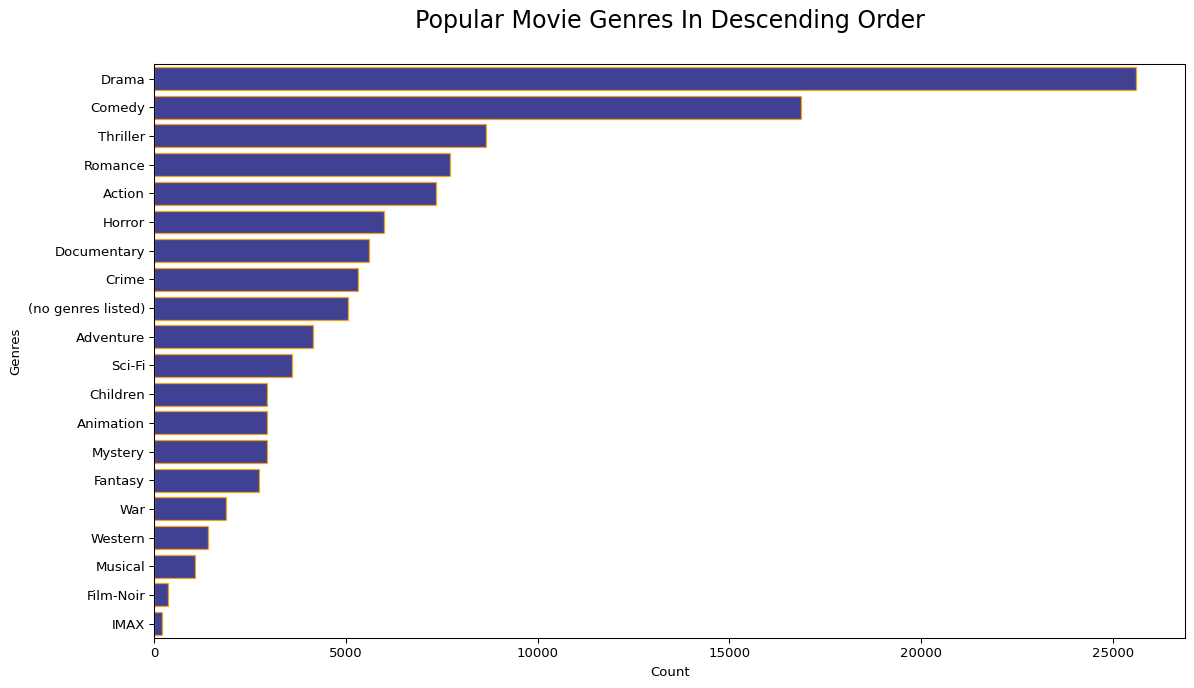

In [37]:
# Ploting the genres in descending order
plot = plt.figure(figsize=(14, 8), dpi =95)
plt.title('Popular Movie Genres In Descending Order\n', fontsize=18)
sns.countplot(y="genres", data=movies_genres_split,order=movies_genres_split['genres']
              .value_counts(ascending=False).index, color='darkblue', ec= 'orange', alpha=0.8)
plt.ylabel('Genres')
plt.xlabel('Count')
plt.show()

For analysis purpose, the code below joins the 'movies', 'imbd', and 'train' dataframes together where movieId in one dataframe is the same as the movieId in the other dataframe

In [38]:
imdb_movies = pd.merge(movies,imdb, on="movieId")
df = imdb_movies.merge(train, on="movieId")
df.head(2)

,movieId,title,genres,title_cast,director,runtime,budget,plot_keywords,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,158849,5.0,994716786
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,97203,5.0,942683155


In [39]:
# getting the average rating for all the ratings related to a specific movie title.
df.groupby(by='title')['rating'].mean()

title
"Great Performances" Cats (1998)             2.753731
$ (Dollars) (1971)                           2.875000
$5 a Day (2008)                              3.125000
$9.99 (2008)                                 3.222222
$ellebrity (Sellebrity) (2012)               2.250000
                                               ...   
À nous la liberté (Freedom for Us) (1931)    3.746914
À propos de Nice (1930)                      3.200000
Árido Movie (2005)                           3.000000
Üvegtigris (2001)                            3.142857
貞子3D (2012)                                  2.562500
Name: rating, Length: 23534, dtype: float64

In [40]:
# Sorting the movies from highest average rating to the lowest rating
df.groupby(by='title')['rating'].mean().sort_values(ascending=False)

title
Wrestling for Jesus: The Tale of T-Money (2011)       5.0
The... Beautiful Country (1977)                       5.0
Only Daughter (2013)                                  5.0
Vasermil (2007)                                       5.0
Day the Universe Changed, The (1985)                  5.0
                                                     ... 
Time to Kill (Tempo di uccidere) (1989)               0.5
Dangerous Place, A (2012)                             0.5
Dana Carvey: Squatting Monkeys Tell No Lies (2008)    0.5
I Love, You Love (Ja milujem, ty milujes) (1989)      0.5
Beautiful Girl (2014)                                 0.5
Name: rating, Length: 23534, dtype: float64

In [41]:
df.groupby(by='title')['rating'].count().sort_values(ascending=False)

title
Shawshank Redemption, The (1994)    32831
Forrest Gump (1994)                 32383
Pulp Fiction (1994)                 31697
Silence of the Lambs, The (1991)    29444
Matrix, The (1999)                  29014
                                    ...  
Christopher Strong (1933)               1
Secrets of the Tribe (2010)             1
Trails (Veredas) (1978)                 1
Train Ride to Hollywood (1975)          1
Seoul Searching (2015)                  1
Name: rating, Length: 23534, dtype: int64

In [42]:
df[df['title'] == "Vietnam in HD (2011)"].groupby(by='title')['rating'].count()

title
Vietnam in HD (2011)    1
Name: rating, dtype: int64

In [43]:
df[df['title'] == "Forrest Gump (1994)"].groupby(by='title')['rating'].mean()

title
Forrest Gump (1994)    4.047216
Name: rating, dtype: float64

In [44]:
print('Runtime column mode is: ',df.runtime.mode())

print('\nRuntime mean is: ',df.runtime.mean())

Runtime column mode is:  0    101.0
dtype: float64

Runtime mean is:  116.09646355365558


<AxesSubplot:xlabel='rating', ylabel='count'>

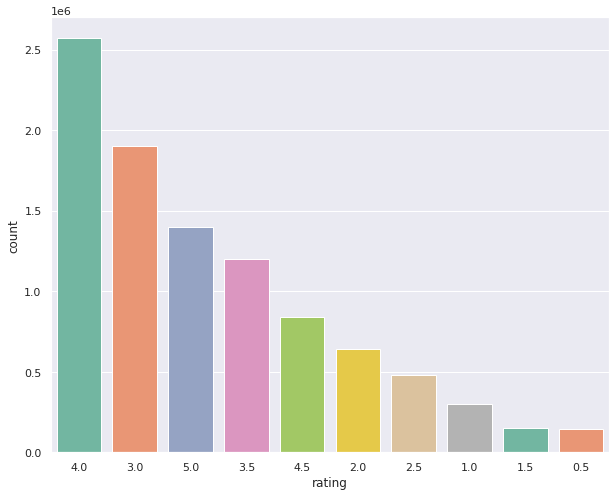

In [45]:
#MOVIES RATINGS
plt.figure(figsize=(10,8))
sns.set(style="darkgrid")
sns.countplot(x="rating", data= df, palette="Set2", order=df['rating'].value_counts().index[0:10])

<AxesSubplot:xlabel='runtime', ylabel='Density'>

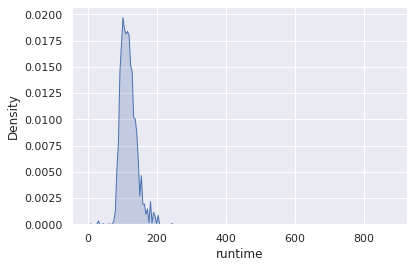

In [46]:
sns.set(style="darkgrid")
sns.kdeplot(data=df['runtime'], shade=True)

In [47]:
df['runtime'].describe().T

count    6.979973e+06
mean     1.160965e+02
std      2.409290e+01
min      1.000000e+00
25%      1.000000e+02
50%      1.130000e+02
75%      1.280000e+02
max      8.770000e+02
Name: runtime, dtype: float64

### 4. Data Engineering

Back to Table of Contents

In [48]:
#creating a copy of the df that will be used for creating content-based and collaborative models
temp_df = df.copy()

In [49]:
#checking for null values
temp_df.isnull().sum()

movieId                0
title                  0
genres                 0
title_cast       2604407
director         2602688
runtime          2653058
budget           3152276
plot_keywords    2610043
userId                 0
rating                 0
timestamp              0
dtype: int64

In [50]:
#removing null values
temp_df.dropna(inplace=True)

In [52]:
#checking null values again to confirm changes
temp_df.isnull().sum()

movieId          0
title            0
genres           0
title_cast       0
director         0
runtime          0
budget           0
plot_keywords    0
userId           0
rating           0
timestamp        0
dtype: int64

In [53]:
#Using regular expressions to find a year stored between parentheses
#We specify the parantheses so we don't conflict with movies that have years in their titles
temp_df['year'] = temp_df.title.str.extract('(\(\d\d\d\d\))',expand=False)
#Removing the parentheses
temp_df['year'] = temp_df.year.str.extract('(\d\d\d\d)',expand=False)
#Removing the years from the 'title' column
temp_df['title'] = temp_df.title.str.replace('(\(\d\d\d\d\))', '')
#Applying the strip function to get rid of any ending whitespace characters that may have appeared
temp_df['title'] = temp_df['title'].apply(lambda x: x.strip())

temp_df.head(2)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


,movieId,title,genres,title_cast,director,runtime,budget,plot_keywords,userId,rating,timestamp,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,158849,5.0,994716786,1995
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,97203,5.0,942683155,1995


In [56]:
# Using regex to clean the movie titles and storing it in the new columns
def clean_titles(title):
    return re.sub("[^a-zA-Z0-9 ]", " ", title)

temp_df["clean_title"] = temp_df["title"].apply(clean_titles)
temp_df.head()

,movieId,title,genres,title_cast,director,runtime,budget,plot_keywords,userId,rating,timestamp,year,clean_title
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,158849,5.0,994716786,1995,Toy Story
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,97203,5.0,942683155,1995,Toy Story
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,161871,3.0,833104576,1995,Toy Story
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,45117,4.0,1442256969,1995,Toy Story
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,27431,5.0,849667827,1995,Toy Story


In [57]:
# Removing | from appropriate columns
temp_df.genres = temp_df.genres.apply(lambda x: x.split('|'))
temp_df.plot_keywords = temp_df.plot_keywords.apply(lambda x: x.split('|'))
temp_df.head(2)

,movieId,title,genres,title_cast,director,runtime,budget,plot_keywords,userId,rating,timestamp,year,clean_title
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000","[toy, rivalry, cowboy, cgi animation]",158849,5.0,994716786,1995,Toy Story
1,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000","[toy, rivalry, cowboy, cgi animation]",97203,5.0,942683155,1995,Toy Story


In [59]:
df['tags']=df['director']+df['genres']+df['plot_keywords']+df['title_cast']

In [60]:
df.head(2)

,movieId,title,genres,title_cast,director,runtime,budget,plot_keywords,userId,rating,timestamp,tags
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,158849,5.0,994716786,John LasseterAdventure|Animation|Children|Come...
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,97203,5.0,942683155,John LasseterAdventure|Animation|Children|Come...


# SKIP NEXT 3 CELLS - FOR NOW

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))
tfidf = vectorizer.fit_transform(temp_df["clean_title"])

In [ ]:
content_df = pd.DataFrame(temp_df[['movieId', 'genres', 'title_cast', 'director', 'plot_keywords','userId', 'year', 'clean_title','rating']],columns=['movieId', 'genres', 'title_cast', 'director', 'plot_keywords','userId', 'year', 'clean_title','rating'])

In [ ]:
content_df.head(2)

# CONTINUE HERE - FOR NOW

In [58]:
def join_cols(col1):
    """ return the content of individual columns as one """
    temp = []
    for i in range(len(col1)):
        temp.append(str(col1.iloc[i]))
    return temp

In [ ]:
df['joined'] = join_cols( df.genres, df.title_cast, df.director)

In [ ]:
# selecting the relevant features for recommendation

selected_features = ['clean_title', 'genres', 'director','title_cast','plot_keywords']
print(selected_features)